# install necessary packages

In [1]:
pip install --upgrade pip -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install --pre pycaret -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.19.1 requires aiohttp, which is not installed.
beatrix-jupyterlab 2023.128.151533 requires jupyterlab~=3.6.0, but you have jupyterlab 4.2.1 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.7.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
osmnx 1.9.3 requires shapely>=2.0, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
xarray 2024.5.0 requires packaging>=23.1, but you have packaging 21.3 which is incompatible.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatibl

# Import packages

In [3]:
import joblib
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns

import xgboost as xgb

import plotly.express as px
import matplotlib.pyplot as plt



from pycaret.classification import *
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc

# Import dataset

In [4]:
df = pd.read_csv('/kaggle/input/ethereum-frauddetection-dataset/transaction_dataset.csv', index_col=0)
df.sample(5)

,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
633,634,0x0f201982723b310de1ce93f59bea8e8d5d268517,0,992.54,1766.00,684983.80,135,312,0,3,...,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,5.0,NaN,Livepeer Token
7665,4,0x0059b14e35dab1b4eee1e2926c7a5660da66f747,1,2300.37,65.10,73091.00,29,98,0,89,...,0.0,81324.0746,5232.816018,0.0,0.0,0.0,22.0,37.0,OCoin,OCoin
1617,1618,0x2a0aec06ca174c021b772b8daa33145f6d4da4c0,0,29205.19,5407.20,880462.72,27,17,0,6,...,5.0,1000.0000,502.500000,0.0,0.0,0.0,1.0,26.0,UselessEthereumToken,Pundi X Token
8209,548,0x3dcf0aa2d91376f974678f509f2e69c88467089c,1,0.00,0.00,0.00,0,0,0,0,...,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,1.0,,Blockwell say NOTSAFU
5897,2965,0x9dadb4060e179e62dda9ce44b0a690cc777d214b,0,0.00,96.88,758527.15,1,3,0,1,...,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,5.0,NaN,Livepeer Token


In [5]:
df.drop(['Index', 'Address'], axis=1, inplace=True)
df.sample(1)

,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
5098,0,219.89,8587.79,1161966.2,90,133,0,3,1,0.01001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN,blockwell.ai KYC Casper Token


# Evaluation with pycaret

In [6]:
setup(df, target='FLAG', session_id=85)

,Description,Value
0,Session id,85
1,Target,FLAG
2,Target type,Binary
3,Original data shape,"(9841, 48)"
4,Transformed data shape,"(9841, 48)"
5,Transformed train set shape,"(6888, 48)"
6,Transformed test set shape,"(2953, 48)"
7,Numeric features,45
8,Categorical features,2
9,Rows with missing values,27.6%


In [7]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.9938,0.9978,0.9771,0.9947,0.9857,0.9818,0.9819,1.2150
lightgbm,Light Gradient Boosting Machine,0.9936,0.9993,0.9751,0.9960,0.9854,0.9813,0.9814,0.6320
et,Extra Trees Classifier,0.9935,0.9995,0.9705,1.0000,0.9850,0.9808,0.9810,0.7480
xgboost,Extreme Gradient Boosting,0.9930,0.9994,0.9744,0.9940,0.9841,0.9796,0.9797,0.5870
catboost,CatBoost Classifier,0.9927,0.9995,0.9731,0.9940,0.9834,0.9788,0.9789,7.4140
rf,Random Forest Classifier,0.9914,0.9987,0.9659,0.9953,0.9803,0.9749,0.9751,1.2560
gbc,Gradient Boosting Classifier,0.9914,0.9991,0.9718,0.9894,0.9805,0.9750,0.9751,4.3460
dt,Decision Tree Classifier,0.9848,0.9778,0.9653,0.9659,0.9656,0.9558,0.9558,0.2750
knn,K Neighbors Classifier,0.9148,0.9335,0.7692,0.8335,0.7998,0.7458,0.7470,0.2400
lda,Linear Discriminant Analysis,0.8991,0.9486,0.5502,0.9891,0.7065,0.6516,0.6928,0.2030


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

AdaBoostClassifier(algorithm='SAMME.R', estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=85)

# EDA

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9841 entries, 0 to 9840
Data columns (total 48 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   FLAG                                                  9841 non-null   int64  
 1   Avg min between sent tnx                              9841 non-null   float64
 2   Avg min between received tnx                          9841 non-null   float64
 3   Time Diff between first and last (Mins)               9841 non-null   float64
 4   Sent tnx                                              9841 non-null   int64  
 5   Received Tnx                                          9841 non-null   int64  
 6   Number of Created Contracts                           9841 non-null   int64  
 7   Unique Received From Addresses                        9841 non-null   int64  
 8   Unique Sent To Addresses                              9841 non-

In [9]:
for column in df: print(f"{column}: {len(df[column].unique())}")

FLAG: 2
Avg min between sent tnx: 5013
Avg min between received tnx: 6223
Time Diff between first and last (Mins): 7810
Sent tnx: 641
Received Tnx: 727
Number of Created Contracts: 20
Unique Received From Addresses: 256
Unique Sent To Addresses: 258
min value received: 4589
max value received : 6302
avg val received: 6767
min val sent: 4719
max val sent: 6647
avg val sent: 5854
min value sent to contract: 3
max val sent to contract: 4
avg value sent to contract: 4
total transactions (including tnx to create contract: 897
total Ether sent: 5868
total ether received: 6728
total ether sent contracts: 4
total ether balance: 5717
 Total ERC20 tnxs: 301
 ERC20 total Ether received: 3461
 ERC20 total ether sent: 1416
 ERC20 total Ether sent contract: 30
 ERC20 uniq sent addr: 108
 ERC20 uniq rec addr: 148
 ERC20 uniq sent addr.1: 5
 ERC20 uniq rec contract addr: 124
 ERC20 avg time between sent tnx: 2
 ERC20 avg time between rec tnx: 2
 ERC20 avg time between rec 2 tnx: 2
 ERC20 avg time betw

In [10]:
df.select_dtypes(include=['float', 'int']).describe()

,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,...,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name
count,9841.000000,9841.000000,9841.000000,9.841000e+03,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,...,9.012000e+03,9.012000e+03,9.012000e+03,9.012000e+03,9.012000e+03,9012.0,9012.0,9012.0,9012.000000,9012.000000
mean,0.221421,5086.878721,8004.851184,2.183333e+05,115.931714,163.700945,3.729702,30.360939,25.840159,43.845153,...,1.252524e+08,4.346203e+06,1.174126e+04,1.303594e+07,6.318389e+06,0.0,0.0,0.0,1.384931,4.826676
std,0.415224,21486.549974,23081.714801,3.229379e+05,757.226361,940.836550,141.445583,298.621112,263.820410,325.929139,...,1.053741e+10,2.141192e+08,1.053567e+06,1.179905e+09,5.914764e+08,0.0,0.0,0.0,6.735121,16.678607
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000
25%,0.000000,0.000000,0.000000,3.169300e+02,1.000000,1.000000,0.000000,1.000000,1.000000,0.001000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000
50%,0.000000,17.340000,509.770000,4.663703e+04,3.000000,4.000000,0.000000,2.000000,2.000000,0.095856,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,1.000000
75%,0.000000,565.470000,5480.390000,3.040710e+05,11.000000,27.000000,0.000000,5.000000,3.000000,2.000000,...,9.900000e+01,2.946467e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,2.000000
max,1.000000,430287.670000,482175.490000,1.954861e+06,10000.000000,10000.000000,9995.000000,9999.000000,9287.000000,10000.000000,...,1.000000e+12,1.724181e+10,1.000000e+08,1.120000e+11,5.614756e+10,0.0,0.0,0.0,213.000000,737.000000


In [11]:
df.FLAG.value_counts(normalize=True) * 100

FLAG
0    77.857941
1    22.142059
Name: proportion, dtype: float64

In [12]:
fig = px.pie(df, names=df.FLAG.value_counts().index, values=df.FLAG.value_counts().values,
             title='Target distribution of being Fraud or not', color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

# Data cleaning

In [13]:
df.isnull().sum()

FLAG                                                       0
Avg min between sent tnx                                   0
Avg min between received tnx                               0
Time Diff between first and last (Mins)                    0
Sent tnx                                                   0
Received Tnx                                               0
Number of Created Contracts                                0
Unique Received From Addresses                             0
Unique Sent To Addresses                                   0
min value received                                         0
max value received                                         0
avg val received                                           0
min val sent                                               0
max val sent                                               0
avg val sent                                               0
min value sent to contract                                 0
max val sent to contract

In [14]:
categories = df.select_dtypes('O').columns.astype('category')
df[categories]

,ERC20 most sent token type,ERC20_most_rec_token_type
0,Cofoundit,Numeraire
1,Livepeer Token,Livepeer Token
2,NaN,XENON
3,Raiden,XENON
4,StatusNetwork,EOS
...,...,...
9836,,GSENetwork
9837,,Blockwell say NOTSAFU
9838,,Free BOB Tokens - BobsRepair.com
9839,NaN,NaN


In [15]:
df.drop(df[categories], axis=1, inplace=True)

In [16]:
df.fillna(df.median(), inplace=True)

In [17]:
df.isnull().sum()

FLAG                                                    0
Avg min between sent tnx                                0
Avg min between received tnx                            0
Time Diff between first and last (Mins)                 0
Sent tnx                                                0
Received Tnx                                            0
Number of Created Contracts                             0
Unique Received From Addresses                          0
Unique Sent To Addresses                                0
min value received                                      0
max value received                                      0
avg val received                                        0
min val sent                                            0
max val sent                                            0
avg val sent                                            0
min value sent to contract                              0
max val sent to contract                                0
avg value sent

In [18]:
df.var()

FLAG                                                    1.724110e-01
Avg min between sent tnx                                4.616718e+08
Avg min between received tnx                            5.327656e+08
Time Diff between first and last (Mins)                 1.042889e+11
Sent tnx                                                5.733918e+05
Received Tnx                                            8.851734e+05
Number of Created Contracts                             2.000685e+04
Unique Received From Addresses                          8.917457e+04
Unique Sent To Addresses                                6.960121e+04
min value received                                      1.062298e+05
max value received                                      1.692294e+08
avg val received                                        8.323238e+06
min val sent                                            1.921264e+04
max val sent                                            4.394646e+07
avg val sent                      

In [19]:
no_variance = df.var() == 0
df.var()[no_variance]

 ERC20 avg time between sent tnx        0.0
 ERC20 avg time between rec tnx         0.0
 ERC20 avg time between rec 2 tnx       0.0
 ERC20 avg time between contract tnx    0.0
 ERC20 min val sent contract            0.0
 ERC20 max val sent contract            0.0
 ERC20 avg val sent contract            0.0
dtype: float64

In [20]:
df.drop(df.var()[no_variance].index, axis=1, inplace=True)

In [21]:
df.shape

(9841, 39)

In [22]:
df.corr()

,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,...,ERC20 uniq sent addr.1,ERC20 uniq rec contract addr,ERC20 min val rec,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 uniq sent token name,ERC20 uniq rec token name
FLAG,1.000000,-0.029754,-0.118533,-0.269354,-0.078006,-0.079316,-0.013711,-0.031941,-0.045584,-0.021641,...,-0.011148,-0.052473,0.004434,-0.005510,0.003132,0.019023,0.018770,0.018835,-0.026290,-0.052603
Avg min between sent tnx,-0.029754,1.000000,0.060979,0.214722,-0.032289,-0.035735,-0.006186,-0.015912,-0.017688,-0.014886,...,-0.011862,0.047946,0.004998,-0.002260,-0.002829,-0.001511,-0.001841,-0.001792,0.003310,0.049548
Avg min between received tnx,-0.118533,0.060979,1.000000,0.303897,-0.040419,-0.053478,-0.008378,-0.029571,-0.025747,-0.045753,...,-0.013750,-0.011693,-0.007794,-0.003326,-0.005241,-0.003545,-0.003568,-0.003521,-0.016831,-0.011684
Time Diff between first and last (Mins),-0.269354,0.214722,0.303897,1.000000,0.154480,0.148376,-0.003881,0.037043,0.071140,-0.084996,...,0.022216,0.324088,-0.008921,0.046278,0.049160,-0.006174,-0.005606,-0.006148,0.269025,0.329237
Sent tnx,-0.078006,-0.032289,-0.040419,0.154480,1.000000,0.198455,0.320603,0.130064,0.670014,0.024015,...,-0.007671,0.221971,-0.003480,0.004445,0.009104,-0.001407,-0.000870,-0.001271,0.082239,0.222945
Received Tnx,-0.079316,-0.035735,-0.053478,0.148376,0.198455,1.000000,-0.003838,0.648655,0.164112,-0.022936,...,0.337827,0.204128,-0.004043,0.015522,0.019382,-0.001735,-0.000584,-0.000763,0.045475,0.205219
Number of Created Contracts,-0.013711,-0.006186,-0.008378,-0.003881,0.320603,-0.003838,1.000000,-0.002211,0.084598,-0.001542,...,-0.000967,0.029421,-0.000724,0.000946,0.002096,-0.000067,0.000173,-0.000046,0.006475,0.030527
Unique Received From Addresses,-0.031941,-0.015912,-0.029571,0.037043,0.130064,0.648655,-0.002211,1.000000,0.159829,-0.012939,...,0.241752,0.149037,-0.001784,0.001691,0.003741,-0.000961,-0.000178,-0.000467,0.042108,0.150158
Unique Sent To Addresses,-0.045584,-0.017688,-0.025747,0.071140,0.670014,0.164112,0.084598,0.159829,1.000000,0.070145,...,-0.004908,0.238617,-0.002093,0.003696,0.005412,-0.000875,-0.000348,-0.000738,0.086414,0.238798
min value received,-0.021641,-0.014886,-0.045753,-0.084996,0.024015,-0.022936,-0.001542,-0.012939,0.070145,1.000000,...,-0.006740,-0.000881,-0.000847,-0.001528,-0.002610,-0.001366,-0.001397,-0.001350,-0.026315,-0.000335


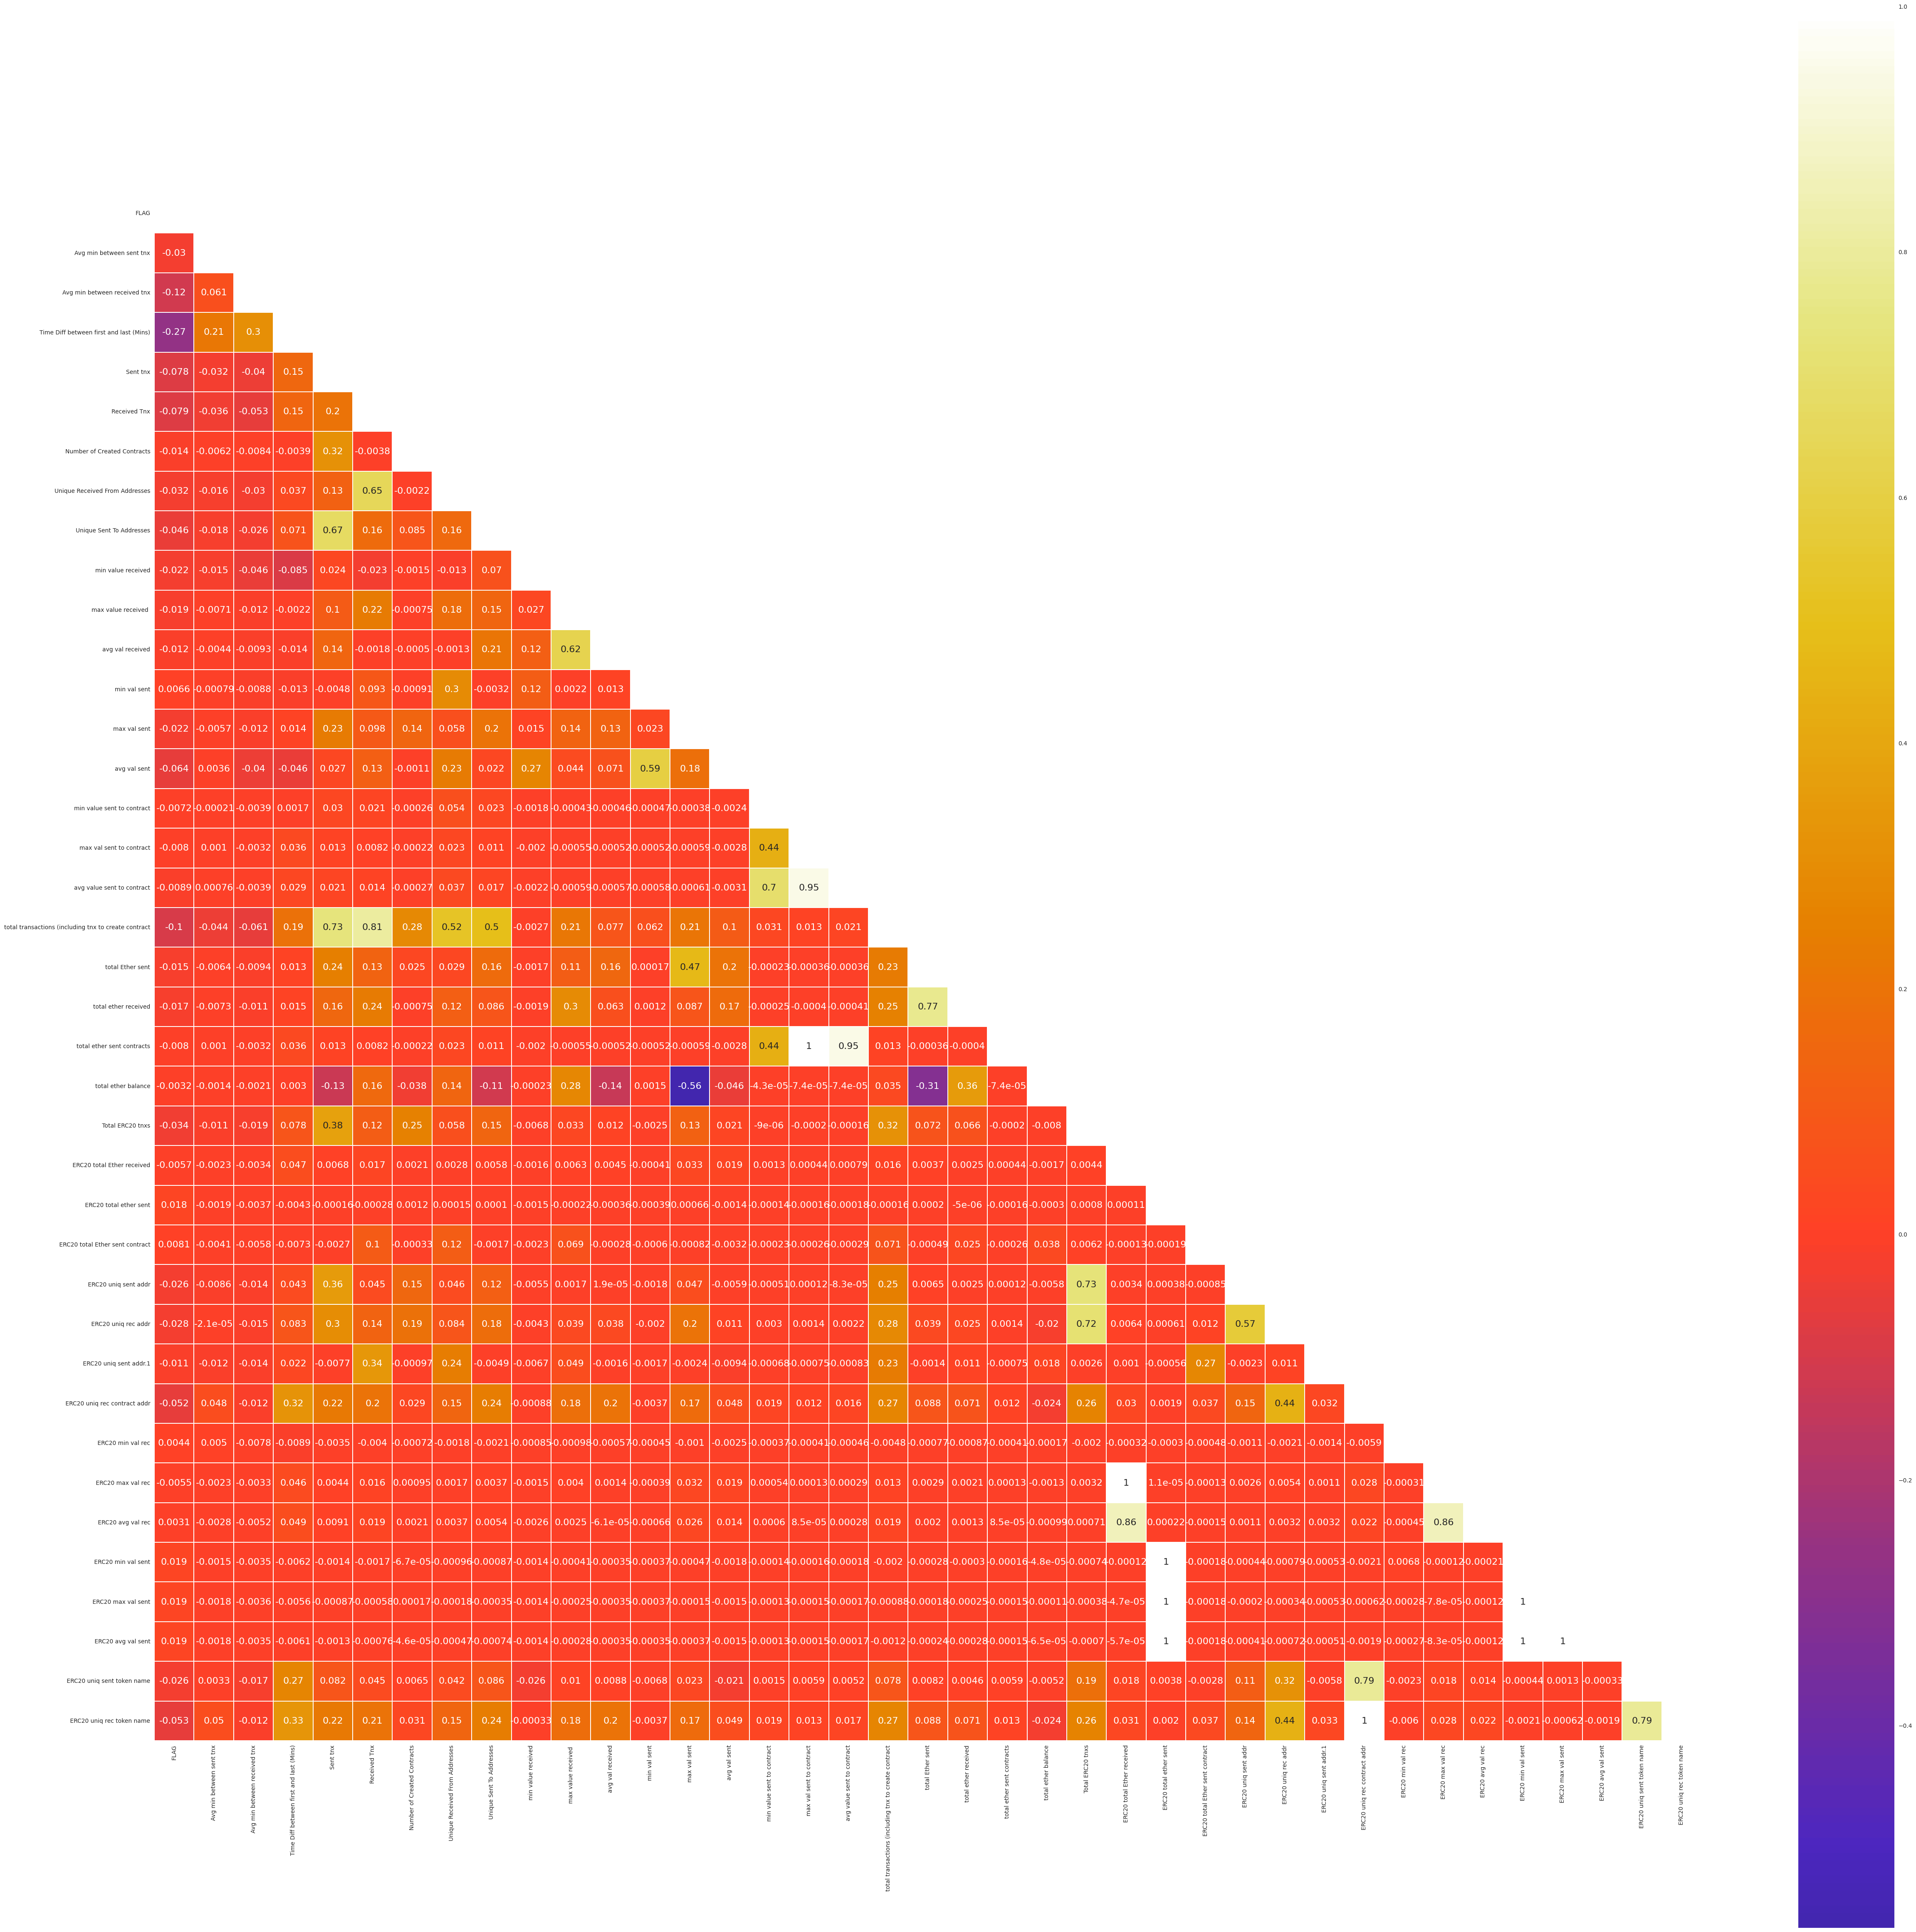

In [23]:
corr = df.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True

with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(60,60))
    sns.heatmap(corr,  mask=mask, annot=True, cmap='CMRmap', center=0, linewidths=0.1, square=True,annot_kws={"size": 16})

In [24]:
sorted_corr = corr.sort_values(by=['FLAG'], key=abs)
sorted_corr

,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,...,ERC20 uniq sent addr.1,ERC20 uniq rec contract addr,ERC20 min val rec,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 uniq sent token name,ERC20 uniq rec token name
ERC20 avg val rec,0.003132,-0.002829,-0.005241,0.049160,0.009104,0.019382,0.002096,0.003741,0.005412,-0.002610,...,0.003207,0.021501,-0.000455,0.859766,1.000000,-0.000205,-0.000117,-0.000123,0.013764,0.022273
total ether balance,-0.003229,-0.001425,-0.002149,0.002955,-0.127211,0.158146,-0.037902,0.144949,-0.113428,-0.000233,...,0.018368,-0.023787,-0.000170,-0.001251,-0.000991,-0.000048,-0.000112,-0.000065,-0.005164,-0.023809
ERC20 min val rec,0.004434,0.004998,-0.007794,-0.008921,-0.003480,-0.004043,-0.000724,-0.001784,-0.002093,-0.000847,...,-0.001367,-0.005930,1.000000,-0.000311,-0.000455,0.006815,-0.000280,-0.000265,-0.002288,-0.006013
ERC20 max val rec,-0.005510,-0.002260,-0.003326,0.046278,0.004445,0.015522,0.000946,0.001691,0.003696,-0.001528,...,0.001051,0.027598,-0.000311,1.000000,0.859766,-0.000121,-0.000078,-0.000083,0.017746,0.028497
ERC20 total Ether received,-0.005711,-0.002339,-0.003430,0.046570,0.006840,0.016648,0.002099,0.002832,0.005809,-0.001580,...,0.001031,0.030039,-0.000322,0.999967,0.859823,-0.000125,-0.000047,-0.000057,0.018349,0.030934
min val sent,0.006626,-0.000789,-0.008761,-0.013107,-0.004846,0.093448,-0.000913,0.296240,-0.003166,0.117682,...,-0.001735,-0.003749,-0.000446,-0.000393,-0.000663,-0.000369,-0.000366,-0.000353,-0.006785,-0.003728
min value sent to contract,-0.007213,-0.000210,-0.003916,0.001734,0.029529,0.020645,-0.000261,0.053946,0.023183,-0.001820,...,-0.000678,0.018886,-0.000372,0.000541,0.000598,-0.000144,-0.000134,-0.000134,0.001533,0.019304
max val sent to contract,-0.007988,0.001044,-0.003230,0.036162,0.013263,0.008243,-0.000225,0.023258,0.010926,-0.002015,...,-0.000750,0.012325,-0.000412,0.000133,0.000085,-0.000160,-0.000155,-0.000151,0.005911,0.012685
total ether sent contracts,-0.007988,0.001044,-0.003230,0.036162,0.013263,0.008243,-0.000225,0.023258,0.010926,-0.002015,...,-0.000750,0.012325,-0.000412,0.000133,0.000085,-0.000160,-0.000155,-0.000151,0.005911,0.012685
ERC20 total Ether sent contract,0.008127,-0.004101,-0.005813,-0.007337,-0.002652,0.104939,-0.000334,0.116755,-0.001697,-0.002331,...,0.274658,0.037021,-0.000477,-0.000125,-0.000154,-0.000184,-0.000183,-0.000177,-0.002817,0.036892


In [25]:
corr['min val sent']

FLAG                                                    0.006626
Avg min between sent tnx                               -0.000789
Avg min between received tnx                           -0.008761
Time Diff between first and last (Mins)                -0.013107
Sent tnx                                               -0.004846
Received Tnx                                            0.093448
Number of Created Contracts                            -0.000913
Unique Received From Addresses                          0.296240
Unique Sent To Addresses                               -0.003166
min value received                                      0.117682
max value received                                      0.002239
avg val received                                        0.012988
min val sent                                            1.000000
max val sent                                            0.022662
avg val sent                                            0.594868
min value sent to contrac

In [26]:
drop = ['total transactions (including tnx to create contract',
        'total ether sent contracts', 
        'max val sent to contract',
        ' ERC20 avg val rec',
        ' ERC20 avg val rec',
        ' ERC20 max val rec', 
        ' ERC20 min val rec', 
        ' ERC20 uniq rec contract addr', 
        'max val sent', 
        ' ERC20 avg val sent',
        ' ERC20 min val sent', 
        ' ERC20 max val sent', 
        ' Total ERC20 tnxs', 
        'avg value sent to contract', 
        'Unique Sent To Addresses',
        'Unique Received From Addresses', 
        'total ether received', 
        ' ERC20 uniq sent token name', 
        'min value received', 
        'min val sent', 
        ' ERC20 uniq rec addr' ]

df.drop(drop, axis=1, inplace=True)

In [27]:
df.sample(5)

,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,max value received,avg val received,avg val sent,min value sent to contract,total Ether sent,total ether balance,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq sent addr.1,ERC20 uniq rec token name
1237,0,9.93,479.76,1171136.88,2612,2387,0,47.090000,0.206679,0.369351,0.0,964.744593,-471.401485,0.01000,100.0,0.0,1.0,0.0,1.0
8049,1,688.73,890.22,22508.33,12,16,0,5.000000,0.943436,1.257160,0.0,15.085925,0.009053,1.33700,0.0,0.0,0.0,0.0,2.0
9738,1,0.00,0.00,0.00,0,1,0,0.004139,0.004139,0.000000,0.0,0.000000,0.004139,1.33700,0.0,0.0,0.0,0.0,1.0
3528,0,36523.41,1561.01,805417.85,15,165,0,53.600000,10.982075,120.801395,0.0,1812.020932,0.021389,2710.48555,0.0,0.0,0.0,0.0,14.0
91,0,13.67,40512.33,688942.00,17,17,0,69.995000,12.287440,12.286790,0.0,208.875430,0.011052,0.00000,0.0,0.0,0.0,0.0,0.0


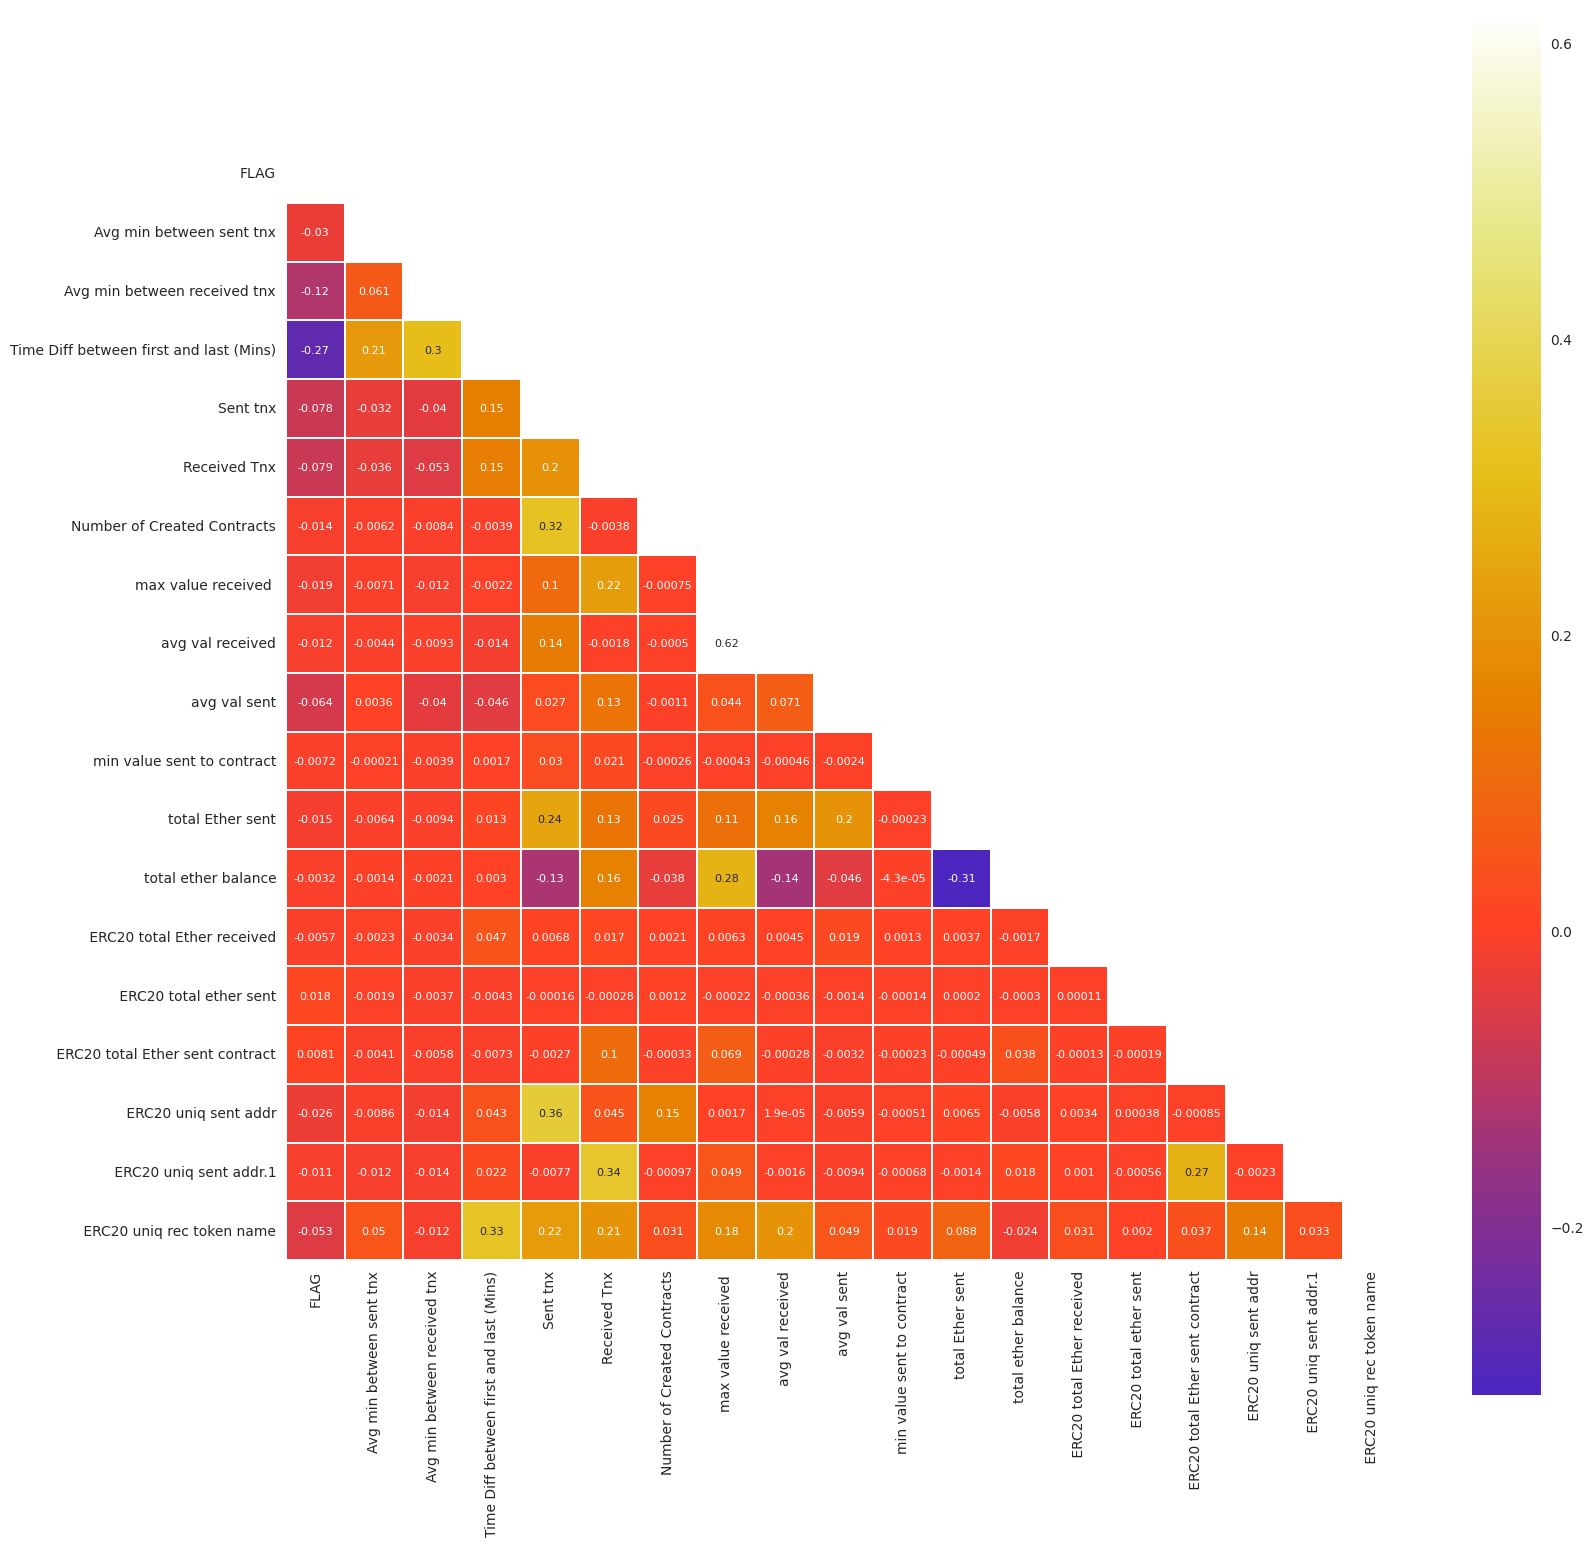

In [28]:
# Recheck the Correlation matrix
corr = df.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True

with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(18,18))
    sns.heatmap(corr,  mask=mask, annot=True, cmap='CMRmap', center=0, linewidths=0.1, square=True,annot_kws={"size": 8})

In [29]:
df.columns

Index(['FLAG', 'Avg min between sent tnx', 'Avg min between received tnx',
       'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx',
       'Number of Created Contracts', 'max value received ',
       'avg val received', 'avg val sent', 'min value sent to contract',
       'total Ether sent', 'total ether balance',
       ' ERC20 total Ether received', ' ERC20 total ether sent',
       ' ERC20 total Ether sent contract', ' ERC20 uniq sent addr',
       ' ERC20 uniq sent addr.1', ' ERC20 uniq rec token name'],
      dtype='object')

In [30]:
# Some features present a small distribution
for column in df.columns[1:]:
    if len(df[column].value_counts()) < 10:
        print(f'The column "{column}" has the following distribution: \n{df[column].value_counts()}')
        print('==========================')

The column "min value sent to contract" has the following distribution: 
min value sent to contract
0.00    9839
0.02       1
0.01       1
Name: count, dtype: int64
The column " ERC20 uniq sent addr.1" has the following distribution: 
 ERC20 uniq sent addr.1
0.0    9813
1.0      26
3.0       1
2.0       1
Name: count, dtype: int64


In [31]:
df.drop(['min value sent to contract', ' ERC20 uniq sent addr.1'], axis=1, inplace=True)
df.head()

,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,max value received,avg val received,avg val sent,total Ether sent,total ether balance,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec token name
0,0,844.26,1093.71,704785.63,721,89,0,45.806785,6.589513,1.200681,865.691093,-279.224419,3.558854e+07,3.560317e+07,0.0,30.0,57.0
1,0,12709.07,2958.44,1218216.73,94,8,0,2.613269,0.385685,0.032844,3.087297,-0.001819,4.034283e+02,2.260809e+00,0.0,1.0,7.0
2,0,246194.54,2434.02,516729.30,2,10,0,1.165453,0.358906,1.794308,3.588616,0.000441,5.215121e+02,0.000000e+00,0.0,0.0,8.0
3,0,10219.60,15785.09,397555.90,25,9,0,500.000000,99.488840,70.001834,1750.045862,-854.646303,1.711105e+04,1.141223e+04,0.0,2.0,11.0
4,0,36.61,10707.77,382472.42,4598,20,1,12.802411,2.671095,0.022688,104.318883,-50.896986,1.628297e+05,1.235399e+05,0.0,4.0,27.0


# Ready data for training

In [32]:
X = df.drop('FLAG', axis=1)
y = df.FLAG

X.shape, y.shape

((9841, 16), (9841,))

In [33]:
# Split into training (80%) and testing set (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

X_train.shape, X_test.shape

((7872, 16), (1969, 16))

In [34]:
standard_scaler = StandardScaler()
standard_scaler_train = standard_scaler.fit_transform(X_train)

In [35]:
standard_scaler_df = pd.DataFrame(standard_scaler_train, columns=X_train.columns)
standard_scaler_df.sample(5)

,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,max value received,avg val received,avg val sent,total Ether sent,total ether balance,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec token name
749,-0.238842,-0.339707,-0.675759,-0.152022,-0.175749,-0.025638,-0.043564,-0.180838,-0.205107,-0.028902,-0.007921,-0.052388,-0.01214,-0.019294,-0.058886,-0.278813
5567,-0.238842,-0.339707,-0.675810,-0.153323,-0.176780,-0.025638,-0.043658,-0.183336,-0.209762,-0.028905,-0.007921,-0.052388,-0.01214,-0.019294,-0.058886,-0.217464
2937,-0.238484,0.158622,-0.095133,-0.132502,-0.160279,-0.025638,-0.029411,-0.138301,-0.125816,-0.028183,-0.007921,-0.052354,-0.01214,-0.019294,-0.058886,-0.217464
7690,-0.238261,2.498575,1.183693,-0.141611,-0.167498,-0.025638,-0.042236,-0.158767,-0.163966,-0.028683,-0.007921,-0.052386,-0.01214,-0.019294,-0.046561,-0.156115
3508,-0.238842,-0.339707,-0.675810,-0.153323,-0.176780,-0.025638,-0.043658,-0.183336,-0.209762,-0.028905,-0.007921,-0.052388,-0.01214,-0.019294,-0.058886,-0.217464


In [36]:
oversample = SMOTE()

print(f'Shape of the training before SMOTE: {standard_scaler_train.shape, y_train.shape}')

Shape of the training before SMOTE: ((7872, 16), (7872,))


In [37]:
X_train_resample, y_train_resample = oversample.fit_resample(standard_scaler_train, y_train)

print(f'Shape of the training after SMOTE: {X_train_resample.shape, y_train_resample.shape}')

Shape of the training after SMOTE: ((12230, 16), (12230,))


In [38]:
# Target distribution before SMOTE
non_fraud = 0
fraud = 0

for i in y_train:
    if i == 0:
        non_fraud +=1
    else:
        fraud +=1

# Target distribution after SMOTE
no = 0
yes = 1

for j in y_train_resample:
    if j == 0:
        no +=1
    else:
        yes +=1


print(f'BEFORE OVERSAMPLING \n \tNon-frauds: {non_fraud} \n \tFauds: {fraud}')
print(f'AFTER OVERSAMPLING \n \tNon-frauds: {no} \n \tFauds: {yes}')

BEFORE OVERSAMPLING 
 	Non-frauds: 6115 
 	Fauds: 1757
AFTER OVERSAMPLING 
 	Non-frauds: 6115 
 	Fauds: 6116


# Model training

In [39]:
LR = LogisticRegression(random_state=42)
LR.fit(X_train_resample, y_train_resample)

standard_scaler_test = standard_scaler.transform(X_test)
LR_y_prediction = LR.predict(standard_scaler_test)

print(classification_report(y_test, LR_y_prediction))

              precision    recall  f1-score   support

           0       0.94      0.54      0.69      1547
           1       0.34      0.87      0.49       422

    accuracy                           0.61      1969
   macro avg       0.64      0.70      0.59      1969
weighted avg       0.81      0.61      0.64      1969



In [40]:
confusion_matrix(y_test, LR_y_prediction)

array([[835, 712],
       [ 55, 367]])

In [41]:
y_test.shape, y_test.value_counts()

((1969,),
 FLAG
 0    1547
 1     422
 Name: count, dtype: int64)

In [42]:
RF = RandomForestClassifier(random_state=42)
RF.fit(X_train_resample, y_train_resample)
RF_y_prediction = RF.predict(standard_scaler_test)

print(classification_report(y_test, RF_y_prediction))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1547
           1       0.93      0.94      0.94       422

    accuracy                           0.97      1969
   macro avg       0.96      0.96      0.96      1969
weighted avg       0.97      0.97      0.97      1969



In [43]:
confusion_matrix(y_test, RF_y_prediction)

array([[1516,   31],
       [  24,  398]])

In [44]:
XGBC = xgb.XGBClassifier(random_state=42)
XGBC.fit(X_train_resample, y_train_resample)
XGBC_y_prediction = XGBC.predict(standard_scaler_test)

print(classification_report(y_test, XGBC_y_prediction))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1547
           1       0.93      0.96      0.95       422

    accuracy                           0.98      1969
   macro avg       0.96      0.97      0.96      1969
weighted avg       0.98      0.98      0.98      1969



In [45]:
confusion_matrix(y_test, XGBC_y_prediction)

array([[1518,   29],
       [  18,  404]])

In [46]:
params_grid = {
    'learning_rate':[0.1, 0.5],
    'n_estimators':[100],
    'subsample':[0.5, 0.9],
    'max_depth':[3, 4],
    'colsample_bytree':[0.7]
}

grid = GridSearchCV(estimator=XGBC, param_grid=params_grid, scoring='recall', cv = 6, verbose = 0)

grid.fit(X_train_resample, y_train_resample)

print(f'Best params found for XGBoost are: {grid.best_params_}')
print(f'Best recall obtained by the best params: {grid.best_score_}')

Best params found for XGBoost are: {'colsample_bytree': 0.7, 'learning_rate': 0.5, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.9}
Best recall obtained by the best params: 0.9836490664306284


In [47]:
y_predict_best_xgb = grid.best_estimator_.predict(standard_scaler_test)

print(classification_report(y_test, y_predict_best_xgb))
print(confusion_matrix(y_test, y_predict_best_xgb))


              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1547
           1       0.93      0.95      0.94       422

    accuracy                           0.97      1969
   macro avg       0.96      0.97      0.96      1969
weighted avg       0.97      0.97      0.97      1969

[[1515   32]
 [  20  402]]


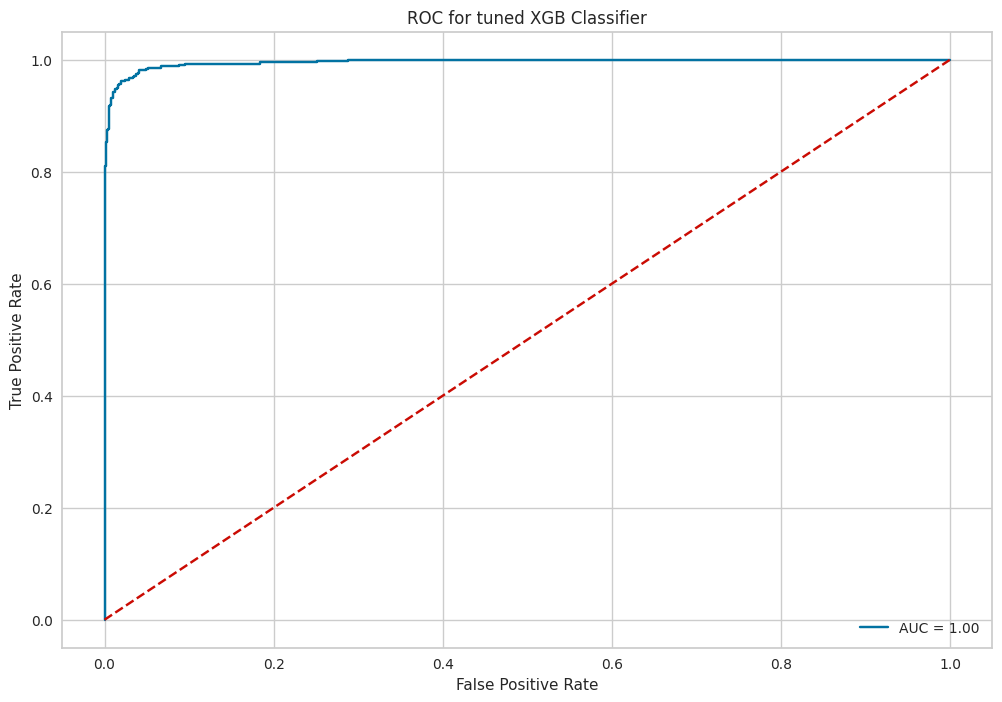

In [48]:
# Plotting AUC for untuned XGB Classifier
probs = XGBC.predict_proba(standard_scaler_test)
pred = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12,8))
plt.title('ROC for tuned XGB Classifier')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()